# ATMS 523 Homework 4
## Wenhan Tang (UIN: 678054985)

### Import packages

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from eofs.xarray import Eof
import warnings
warnings.filterwarnings("ignore")

### Creat dataset

In [2]:
ds = xr.open_dataset("data_sst_tcwv.nc")
ds_land_sea_mask = xr.open_dataset("lsm.nc")
lsm = ds_land_sea_mask["lsm"][0]
lsm = np.where(lsm == 0, True, False)
ds["sst"] = ds["sst"].where(lsm)
ds = ds.coarsen(latitude=8, longitude=8, boundary='trim').mean()
ds.to_netcdf("SST_TCWV_masked.nc")

### Functions for detrending and normalization

In [3]:
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)

    def _trend(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return trend
        
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        trend = _trend(da)
        return (da - trend).astype("float32")
        
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj),\
            obj.map(_trend) if isinstance(obj, xr.Dataset) else _trend(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z, clim_mean, safe_std


def unstandardize(
    z: xr.DataArray,
    clim_mean: xr.DataArray,
    clim_std: xr.DataArray,
    time_dim: xr.DataArray,
):
    key = f"{time_dim}.month"
    return (z.groupby(key) * clim_std).groupby(key) + clim_mean

ds = ds.chunk({"valid_time": -1})

detr, trend = linear_detrend(ds[["sst", "tcwv"]], time_dim="valid_time")   # or just ds if you want all float vars
anom, z, clim_mean, clim_std = monthly_anom_and_z(detr, time_dim="valid_time",
                             base_period=("1981-01-01", "2010-12-31"))  # or None for full-period

### Run EOF solver

In [4]:
coslat = np.cos(np.deg2rad(anom.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(z["sst"].rename({"valid_time": "time"}), weights=wgts)

In [5]:
n_maps = 5
eof1 = solver.eofsAsCorrelation(neofs=n_maps)
pc1 = solver.pcs(npcs=n_maps, pcscaling=1)

### Visualization functions

In [6]:
def plot_map(da, ax, clevs = None, cmap = None):
    if cmap is None: cmap = plt.cm.RdBu_r
    fill = da.plot.contourf(ax=ax, levels=clevs, cmap=cmap,
                                 add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    return fill, ax
    
def plot_eof(eof, pc, ax1, ax2, iEOF):
    
    clevs = np.linspace(-1, 1, 11)
    fill, ax = plot_map(eof, ax1, clevs)
    cb = plt.colorbar(fill, orientation='vertical')
    cb.set_label('correlation coefficient', fontsize=12)
    ax1.set_title("EOF%d expressed as correlation" % (iEOF), fontsize=16)
    
    pc[:].plot(ax = ax2, color='b', linewidth=2)
    ax2 = plt.gca()
    ax2.axhline(0, color='k')
    ax2.set_ylim(-3, 3)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Normalized Units')
    ax2.set_title('PC%d Time Series' % (iEOF), fontsize=16)

### Results – Five EOFs and their corresponding time series

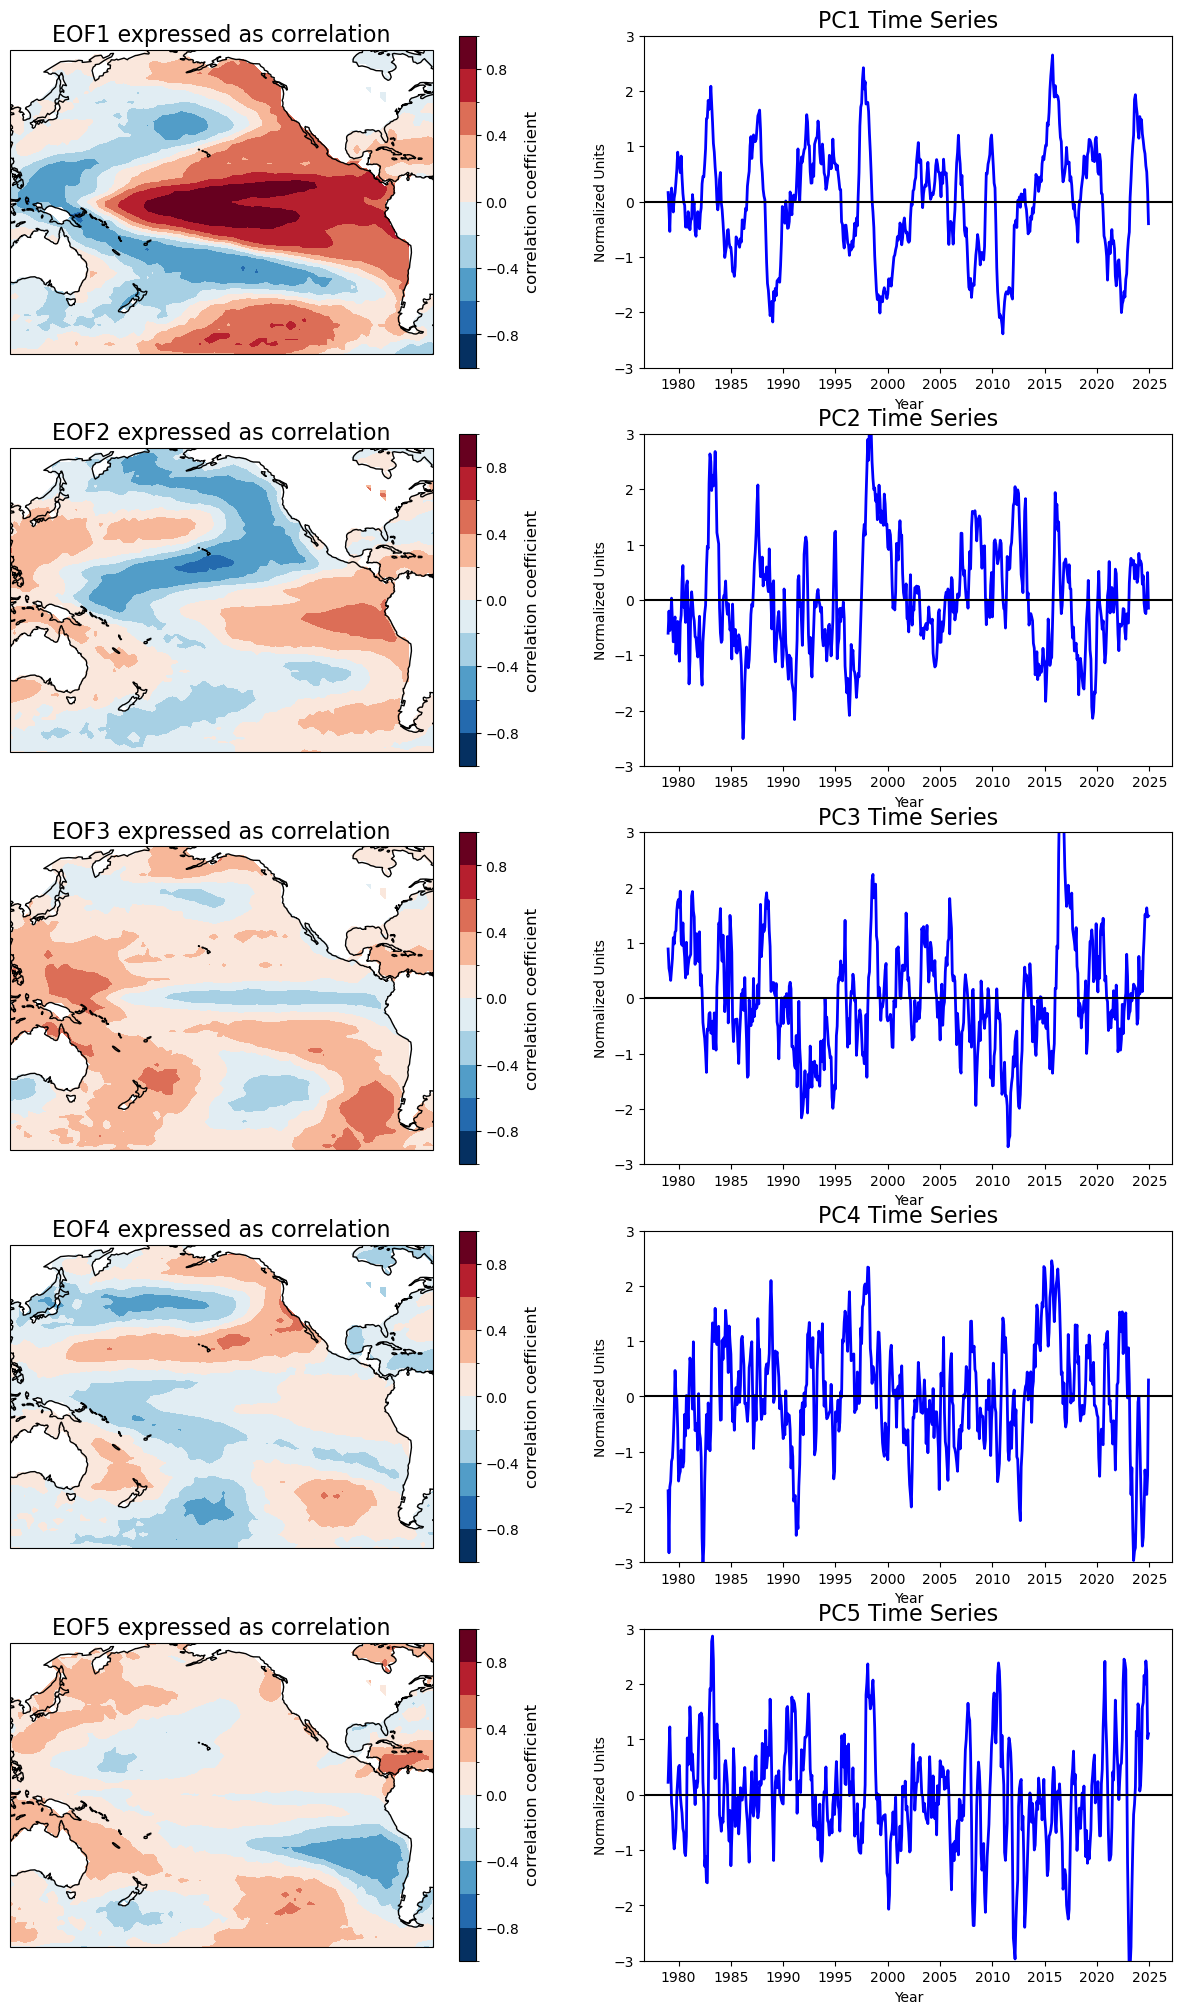

In [7]:
fig = plt.figure(figsize = (15, 25))

for i in range(n_maps):
    ax1 = fig.add_subplot(n_maps, 2, i * 2 + 1, projection = ccrs.PlateCarree(central_longitude=190))
    ax2 = fig.add_subplot(n_maps, 2, i * 2 + 2)
    plot_eof(eof1[i], pc1[:, i], ax1, ax2, i+1)
    

### Variance Explained by Each EOF Mode

(1.093398239787255e-14, 18.901248931884766)

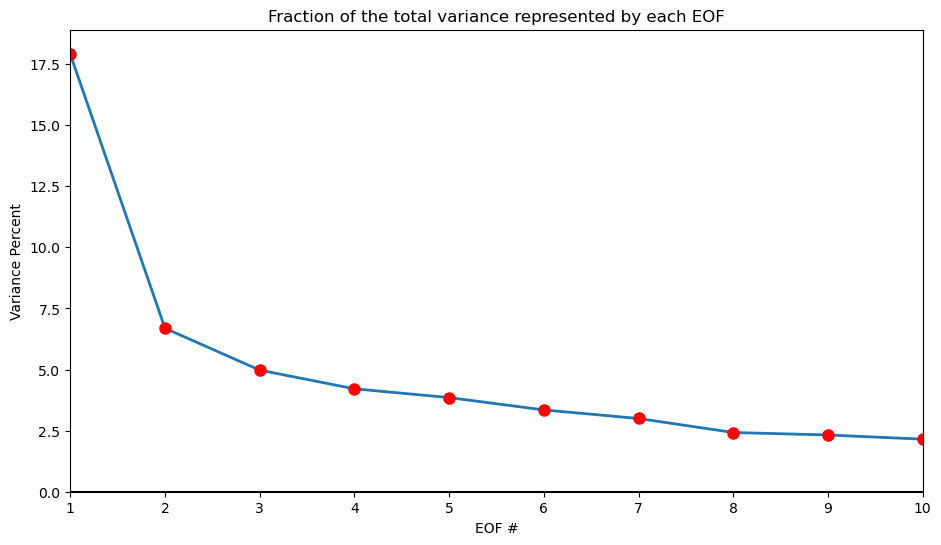

In [8]:
varfrac = solver.varianceFraction()
n_eofs_show = 10
plt.figure(figsize=(11,6))
eof_num = range(1, n_eofs_show +1)
plt.plot(eof_num, varfrac[0:n_eofs_show]*100, linewidth=2)
plt.plot(eof_num, varfrac[0:n_eofs_show]*100, linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, n_eofs_show+1))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Percent')
plt.xlim(1, n_eofs_show)
plt.ylim(np.min(varfrac)*100, np.max(varfrac)*100+1)

### SST reconstruction

In [9]:
def fun_reconstruction(n_EOFs):
    reconstruction = solver.reconstructedField(n_EOFs)
    reconstruction = reconstruction.rename({"time": "valid_time"})
    reconstruction = unstandardize(reconstruction, clim_mean, clim_std, time_dim = "valid_time")
    reconstruction = reconstruction + trend
    return reconstruction
    
reconstruction_5 = fun_reconstruction(5)

### Result - Correlation coefficient between EOF1–5 reconstructed SST and the original SST

Text(0.5, 1.0, 'Correlation coefficient between EOF1–5 reconstructed SST and the original SST')

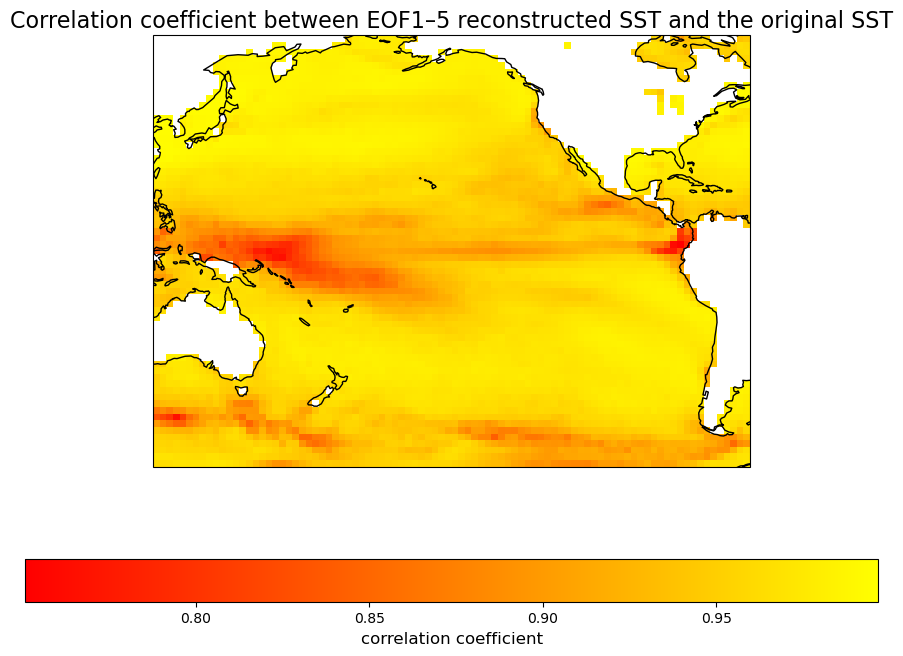

In [10]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
sst_corr = xr.corr(reconstruction_5["sst"], ds["sst"], dim="valid_time")
fig = plt.figure(figsize = (11, 8))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree(central_longitude=190))
fill = sst_corr.plot.pcolormesh(ax=ax, levels=None, cmap="autumn",
                                 add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = fig.colorbar(fill, ax = ax, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title("Correlation coefficient between EOF1–5 reconstructed SST and the original SST", fontsize=16)

### Result - Correlation coefficient between the EOF1 time series and the detrended, deseasonalized, and standardized TCWV

Text(0.5, 1.0, 'Correlation coefficient between EOF1 time series and standardized TCWV')

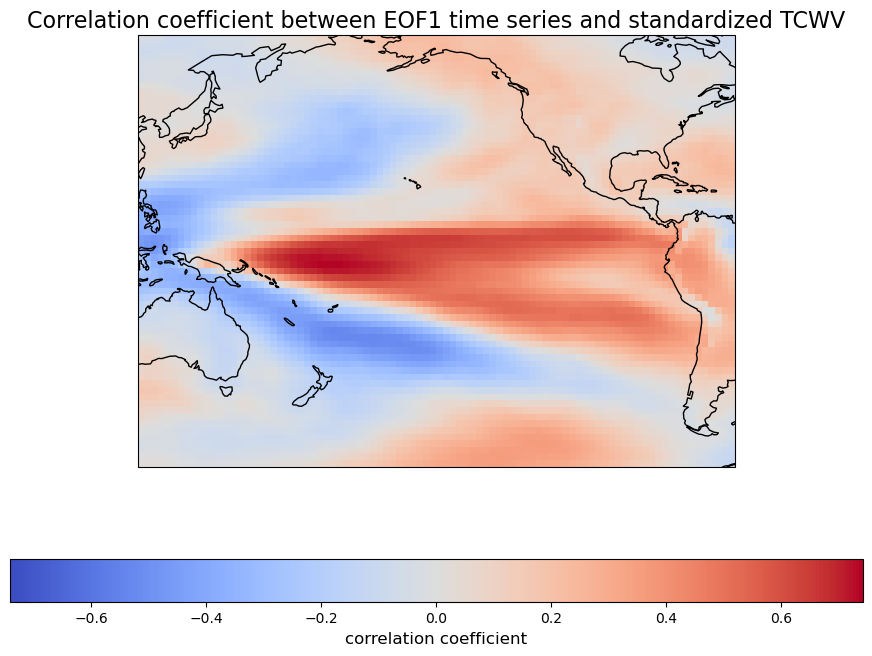

In [11]:
tcwv_corr = xr.corr(pc1[:, 0].rename({"time": "valid_time"}), z["tcwv"], dim="valid_time")
fig = plt.figure(figsize = (11, 8))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree(central_longitude=190))
fill = tcwv_corr.plot.pcolormesh(ax=ax, levels=None, cmap="coolwarm",
                                 add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = fig.colorbar(fill, ax = ax, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title("Correlation coefficient between EOF1 time series and standardized TCWV", fontsize=16)